In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd /content/drive/My\ Drive/dcec
%ls

[Errno 2] No such file or directory: '/content/drive/My Drive/dcec'
/content
sample_data/


In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras import Model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import tensorflow as tf
import scipy
import seaborn as sns

from sklearn.metrics.cluster import contingency_matrix

from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Replication of Results

### HyperParameters Found in the Paper
- Batch size 256
- Epochs 200

```

In [0]:
img_rows, img_cols = 28, 28
batch_size = 256
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

11493376/11490434 [==============================] - 1s 0us/step
MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [0]:
def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10], use_norm=False):
    model = keras.models.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
    model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))
    model.add(Flatten())
    
    if use_norm:
      model.add(Dense(units=filters[3], name='dense1'))
      model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1), name='embedding'))
    else:
      model.add(Dense(units=filters[3], name='embedding'))

    model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))
    model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
    model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
    model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model


In [0]:
cae_l2 = CAE(use_norm=True)

#cae.compile(optimizer='adam', loss='mse')
cae_l2.compile(optimizer='adam', loss='mse')


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense1 (Dense)               (None, 10)                11530     
_________________________________________________________________
embedding (Lambda)           (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1152)             

# Model without $L_2$ Norm 

In [0]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae.save_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")
else:
  cae.load_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 10s 160us/step - loss: 0.0330
Epoch 2/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0169
Epoch 3/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0151
Epoch 4/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0142
Epoch 5/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0135
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0130
Epoch 7/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0126
Epoch 8/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0122
Epoch 9/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0119
Epoch 10/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.0117
Epoch 11/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.0115
Epoch 12/100
60000/60000 [=============

# Model with $L_2$ Norm

In [0]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae_l2.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          steps_per_epoch = batch_size
          verbose=1)
          # callbacks=[checkpoint])

  cae_l2.save_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")
else:
  cae_l2.load_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 9s 155us/step - loss: 0.0441
Epoch 2/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0213
Epoch 3/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0181
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0167
Epoch 5/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0157
Epoch 6/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0151
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0146
Epoch 8/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0142
Epoch 9/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0138
Epoch 10/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0135
Epoch 11/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0133
Epoch 12/100
60000/60000 [==============

KeyboardInterrupt: ignored

In [0]:
%ls -l weights

ls: cannot access 'weights': No such file or directory


In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans


In [0]:
#From https://github.com/michaal94/torch_DCEC
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
def create_anomaly(digit):
  anomaly_digit = digit
  print(f"Using {anomaly_digit} as anomaly dropping 90% of the training samples")

  anomalies = mnist_train_labels == anomaly_digit
  selection = np.ones(len(mnist_train_labels), dtype=np.bool)
  selection[anomalies] = 0
  _selection_anomalies = np.random.choice(len(mnist_train_labels), int(anomalies.sum() * 0.10), replace=False, p=anomalies / anomalies.sum())
  selection[_selection_anomalies] = 1

  anomaly_train_data = mnist_train_data[selection]
  anomaly_train_labels = mnist_train_labels[selection]
  x = anomaly_train_data
  y = anomaly_train_labels
  return x, y


In [0]:
#From https://github.com/michaal94/torch_DCEC

from sklearn.utils.linear_assignment_ import linear_assignment

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def make_clustering_model(x,y,n_clusters, index, maxiter, update_interval,index_array,loss,tol):
  clustering_layer = ClusteringLayer(n_clusters=9, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer='adam', loss='kld')

  kmeans = KMeans(n_clusters=n_clusters, n_init=20)
  y_pred = kmeans.fit_predict(encoder.predict(x))

  y_pred_last = np.copy(y_pred)
  model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(x, verbose=0)
          p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
          y_pred = q.argmax(1)
        # check stop criterion
          delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
          y_pred_last = np.copy(y_pred)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
      loss = model.train_on_batch(x=x[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

  model.save_weights('/content/drive/My Drive/d1' + mnist_digit + 'l2_cl_iter1.h5')
  return model


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [0]:
import os
def cae_model(useNorm):
  if useNorm==False:
    cae = CAE()
    print('Using no l2 CAE')
  elif useNorm==True:
    cae = CAE(use_norm=True)
    print('Using l2 CAE')
  return cae

mnist_digit = '0'
digit_int = 0
#cae = cae_model(useNorm = True)
#cae.compile(optimizer="adam", loss="mse")
#cae.load_weights('/content/d' + mnist_digit + '_with_l2_f0_e200_b256.h5')
encoder = keras.Model(inputs=cea_l2_anomaly.input, outputs=cea_l2_anomaly.get_layer(name='embedding').output)

#Values set as described in https://github.com/michaal94/torch_DCEC. Tol can be changed to 0.01 from smaller datasets
x, y = create_anomaly(digit=digit_int)
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 
n_clusters=9

model = make_clustering_model(x,y,n_clusters, index, maxiter, update_interval,index_array,loss,tol)


Using 0 as anomaly dropping 90% of the training samples


In [0]:
def cluster_emb(emb, n_clusters=9):
  clf = KMeans(n_clusters=n_clusters)
  cluster_dist = clf.fit_transform(emb)
  labels = clf.predict(emb)
  return labels, cluster_dist, clf


def m(y_true, y_pred):
  """Find a mapping from ground truth to kmeans labels"""
  cm = contingency_matrix(y_pred, y_true)
  # print(cm)
  # print(np.argmax(cm, axis=1))
  _, assignment = scipy.optimize.linear_sum_assignment(-cm)
  print(assignment)
  return np.asarray([assignment[l] for l in y_pred])


def plot_tnse(data, titles, y_true, layout, selection_size=1000):
  tsne_selection = np.random.permutation(len(embeddings))[:selection_size]
  for i, ((_d, _y_pred), _t), in enumerate(zip(data, titles)):
    tsne_emb = TSNE(n_components=2).fit_transform(_d[tsne_selection])
    labels_m = m(y_true, _y_pred)
    plt.subplot(*layout, i+1)
    g = sns.scatterplot(tsne_emb[:, 0], tsne_emb[:, 1], hue=labels[tsne_selection], legend="full", palette="Paired").set_title(f"TNSE of {_t} (N={selection_size})")
    
def report(y_true, labels_unmapped):
  mapping = m(y_true, labels_unmapped)
  print(classification_report(y_true, mapping))
  print("Accuracy: ", (y_true == mapping).mean())


def get_emb(_model, data):
  encoder = keras.Model(inputs=_model.input, outputs=_model.get_layer(name='embedding').output)
  return encoder.predict(data)

# Anomaly Detection



Take a random digit and drop 10% in the train set

In [0]:

def calc_emb(model):
  emb = get_emb(model, mnist_train_data)
  labels_a, clusters_a, clf_a = cluster_emb(emb, n_clusters=9)
  return labels_a, clusters_a, clf_a, emb 

def compute_normality(C, emb):
  norm = emb @ (C.T / np.linalg.norm(C, ord=2, axis=1))
  return norm.max(axis=1)

def calc_auc(model, anomaly_digit):
  labels_a, clusters_a, clf_a, emb = calc_emb(model=model)
  normality = compute_normality(clf_a.cluster_centers_, get_emb(model, mnist_test_data))
  plt.hist(normality)

  fpr, tpr, thresholds = metrics.roc_curve(mnist_test_labels == anomaly_digit, 1-normality, pos_label=1)
  auc_digit = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f"ROC AUC={auc_digit:0.3f}", c="r")
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating curve for {anomaly_digit}')
  plt.legend(loc="lower right")
  plt.show()

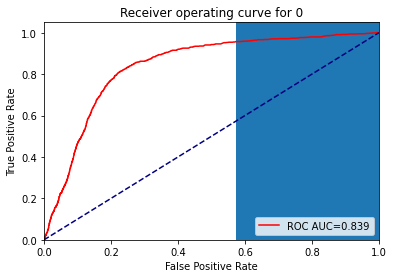

In [0]:
model.load_weights('/content/drive/My Drive/d0no_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=0)

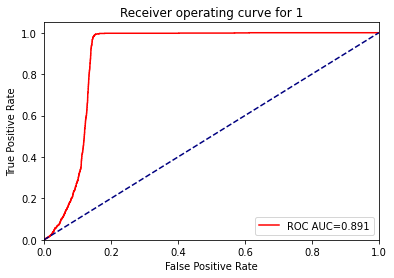

In [0]:
model.load_weights('/content/drive/My Drive/d1no_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=1)

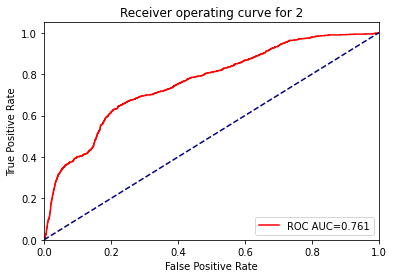

In [0]:
model.load_weights('/content/drive/My Drive/d22no_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=2)

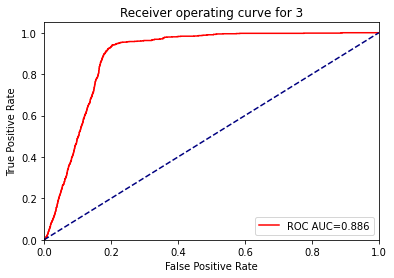

In [0]:
model.load_weights('/content/drive/My Drive/d3no_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=3)

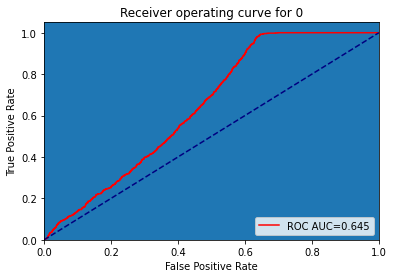

In [0]:
model.load_weights('/content/drive/My Drive/d00_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=0)

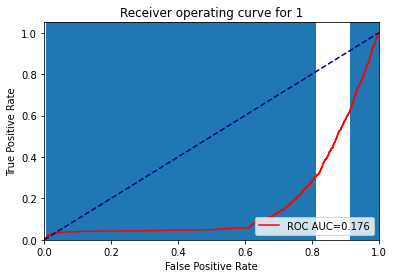

In [0]:
model.load_weights('/content/drive/My Drive/d1_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=1)

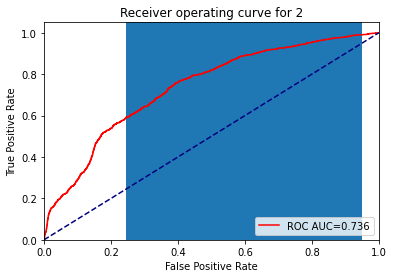

In [0]:
model.load_weights('/content/drive/My Drive/d2_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=2)

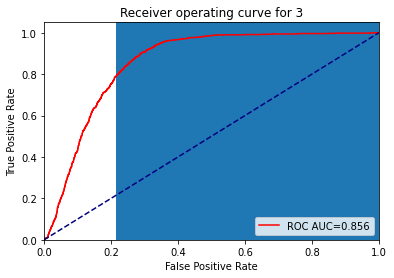

In [0]:
model.load_weights('/content/drive/My Drive/d3_l2_cl_iter1.h5')
calc_auc(model, anomaly_digit=3)